# Setup

In [1]:
!pip install torchaudio datasets librosa torchlibrosa ftfy braceexpand wget webdataset wandb --quiet


In [2]:
#@title Mount drive & Clone GitHub
import os, shutil, getpass
from google.colab import drive

update_drive_copy = True #@param {type:"boolean"}

REPO_NAME = "Audio-ResiDual"
DRIVE_DIR_NAME = 'Progetto Deep' #@param {type:"string"}
DRIVE_PATH = '/content/drive/MyDrive/' + DRIVE_DIR_NAME + '/'
TARGET_DIR = os.path.join(DRIVE_PATH, REPO_NAME)

drive.mount('/content/drive')

GITHUB_USER = "arianna011" #@param {type: "string"}

if update_drive_copy or not os.path.exists(TARGET_DIR):
  GITHUB_URL = f"https://github.com/{GITHUB_USER}/{REPO_NAME}.git"
  TEMP_CLONE_DIR = f"/content/{REPO_NAME}"

  if os.path.exists(TEMP_CLONE_DIR):
      shutil.rmtree(TEMP_CLONE_DIR)

  print(f"Cloning {REPO_NAME} into Colab RAM...")
  exit_code = os.system(f'git clone "{GITHUB_URL}" "{TEMP_CLONE_DIR}"')

  if exit_code == 0:
      print(f"Copying to Google Drive into {TARGET_DIR}")
      if os.path.exists(TARGET_DIR):
          shutil.rmtree(TARGET_DIR)
      shutil.copytree(TEMP_CLONE_DIR, TARGET_DIR)
      print("Done")
  else:
      print("Clone failed")

CLAP_path = os.path.join(TARGET_DIR, "CLAP")
ResiDual_path = os.path.join(TARGET_DIR, "ResiDual")
%cd "{TARGET_DIR}"
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning Audio-ResiDual into Colab RAM...
Copying to Google Drive into /content/drive/MyDrive/Progetto Deep/Audio-ResiDual
Done
/content/drive/MyDrive/Progetto Deep/Audio-ResiDual
1_Analyze_CLAP_Attention.ipynb	CLAP		 README.md  src
2_Apply_ResiDual_on_CLAP.ipynb	data_processing  ResiDual


In [3]:
#@title Imports
import torch
import os
from tqdm import tqdm
import pandas as pd
import librosa
import IPython.display as ipd
import math, random
import torchaudio
from torchaudio import transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import gc
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import data_processing
from data_processing import AudioDataset, get_dataframe, DATASETS, get_fold_dataloaders
from CLAP.src.laion_clap import htsat, model, CLAP_Module
from CLAP.src import get_audio_features
from src import evaluation as E
from src import linear as L

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Evaluation of CLAP

The goal of this notebook is to evaluate different versions of CLAP and compare their performance. In particular:
- the default pretrained CLAP checkpoint (baseline);
- the ResiDual CLAP (trained with the best hyperparameters from the previous notebook);
- the baseline CLAP with an added final linear projection layer \\

are tested on the **audio classification** downstream task.

In [4]:
#@title Load dataset
DATASET = 'ESC50' #@param ['ESC50', 'UrbanSound8K']
batch_sz = 64 #@param {type:"slider", min:1, max:256, step:1}
audio_dir = os.path.join(TARGET_DIR, DATASETS[DATASET]["audio_dir"])
dataset = AudioDataset(DATASET, get_dataframe(DATASET, cwd=TARGET_DIR), audio_dir)
folds = get_fold_dataloaders(dataset, batch_size=batch_sz, shuffle=False)

Download complete.
ZIP extraction complete.


### Load HTSAT

In [5]:
clap = CLAP_Module(enable_fusion=False)
clap.load_ckpt() # download default pretrained checkpoint

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# get text embeddings for zero-shot classification
class_names = DATASETS[DATASET]["class_labels"]
text_prompts = [f"A sound of {cls.replace('_', ' ')}" for cls in class_names]
with torch.no_grad():
    text_embeds = clap.get_text_embedding(text_prompts)
text_embeds = torch.tensor(text_embeds, dtype=torch.float32)

In [7]:
save_dir = os.path.join(DRIVE_PATH, "eval_results")

## Evaluation of Pretrained CLAP

In [8]:
# evaluate and save results on file
E.evaluate_baseline_clap(clap, DATASET, folds, text_embeds, save_dir)

0it [00:00, ?it/s]
Evaluating (zero-shot): 100%|██████████| 7/7 [00:19<00:00,  2.72s/it]
1it [00:19, 19.06s/it]
Evaluating (zero-shot): 100%|██████████| 7/7 [00:17<00:00,  2.52s/it]
2it [00:36, 18.23s/it]
Evaluating (zero-shot): 100%|██████████| 7/7 [00:15<00:00,  2.23s/it]
3it [00:52, 17.04s/it]
Evaluating (zero-shot): 100%|██████████| 7/7 [00:14<00:00,  2.13s/it]
4it [01:07, 16.21s/it]
Evaluating (zero-shot): 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]
5it [01:21, 16.38s/it]


== Cross-Fold Evaluation Metrics ==
Top-1 Accuracy:   0.8790 ± 0.0245
Top-5 Accuracy:  0.9830 ± 0.0076
Precision: 0.9024 ± 0.0284
Recall:    0.8790 ± 0.0245
F1:        0.8691 ± 0.0259


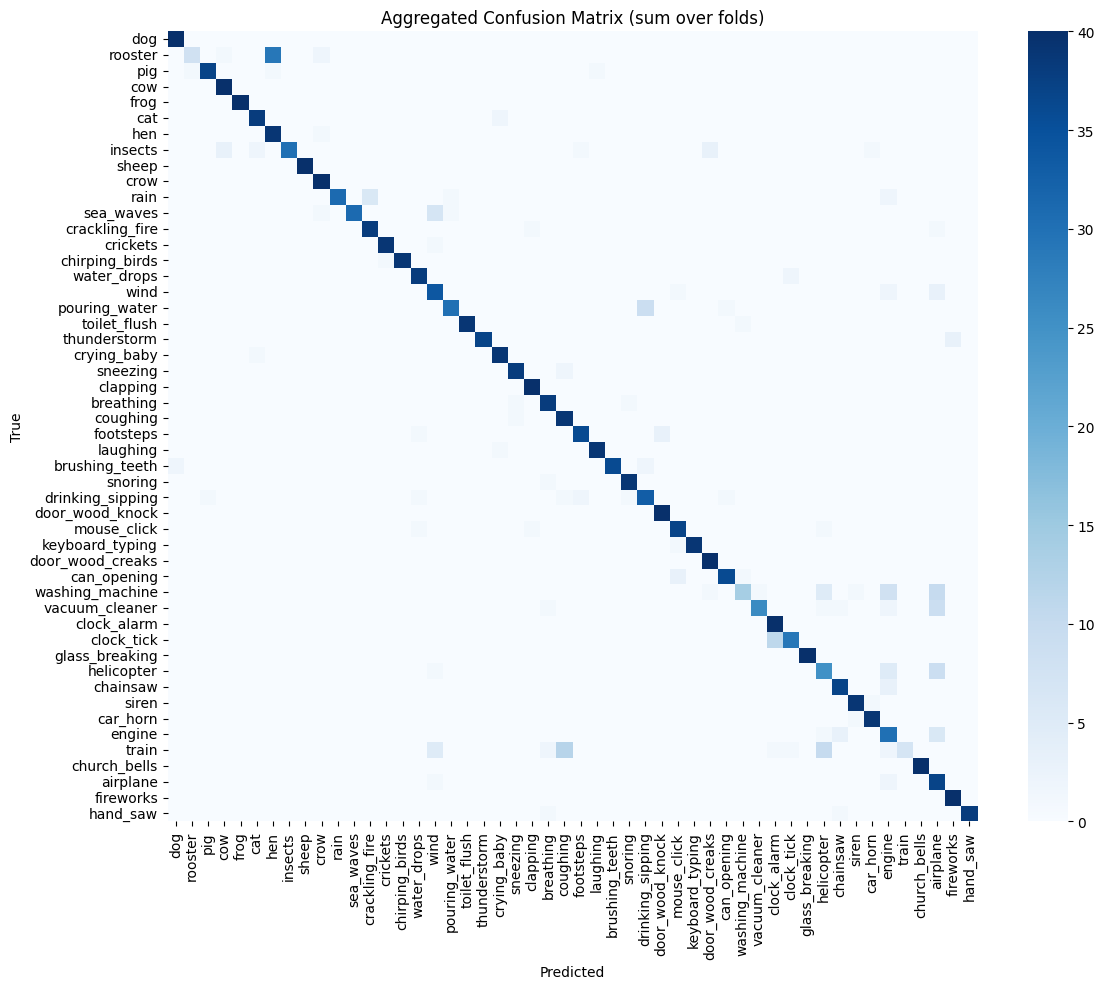

In [10]:
baseline_dir = os.path.join(save_dir, DATASET, "Baseline")
E.visualize_eval_metrics(baseline_dir, DATASET, DATASETS[DATASET]["n_folds"], [])

## Evaluation of ResiDual CLAP

In [12]:
pca_path = os.path.join(DRIVE_PATH, "residual_pca")
E.train_and_evaluate_residual(clap, DATASET, folds, text_embeds, pca_path, save_dir, epochs=20)

===== Eval fold 0 =====
=== Epoch 0 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


Train loss: 3.5770667934417726, Train accuracy: 0.7825
=== Epoch 1 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.5646941375732424, Train accuracy: 0.806875
=== Epoch 2 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


Train loss: 3.5538358974456785, Train accuracy: 0.833125
=== Epoch 3 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Train loss: 3.5470252227783203, Train accuracy: 0.849375
=== Epoch 4 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.5436056804656983, Train accuracy: 0.851875
=== Epoch 5 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.5407423210144042, Train accuracy: 0.85125
=== Epoch 6 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Train loss: 3.5381588554382324, Train accuracy: 0.851875
=== Epoch 7 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


Train loss: 3.5355689239501955, Train accuracy: 0.854375
=== Epoch 8 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


Train loss: 3.5329675388336184, Train accuracy: 0.855625
=== Epoch 9 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Train loss: 3.5308588886260988, Train accuracy: 0.86
=== Epoch 10 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


Train loss: 3.529439353942871, Train accuracy: 0.86
=== Epoch 11 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.528440523147583, Train accuracy: 0.860625
=== Epoch 12 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.527669267654419, Train accuracy: 0.860625
=== Epoch 13 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.5270387363433837, Train accuracy: 0.86375
=== Epoch 14 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


Train loss: 3.5264957332611084, Train accuracy: 0.86375
=== Epoch 15 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Train loss: 3.526020164489746, Train accuracy: 0.86625
=== Epoch 16 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.525588788986206, Train accuracy: 0.86625
=== Epoch 17 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.12s/it]


Train loss: 3.5251914119720458, Train accuracy: 0.8675
=== Epoch 18 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.524844331741333, Train accuracy: 0.869375
=== Epoch 19 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Train loss: 3.524520378112793, Train accuracy: 0.869375


Evaluating (zero-shot): 100%|██████████| 7/7 [00:15<00:00,  2.18s/it]


===== Eval fold 1 =====
=== Epoch 0 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.12s/it]


Train loss: 3.574693956375122, Train accuracy: 0.79375
=== Epoch 1 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.562676200866699, Train accuracy: 0.816875
=== Epoch 2 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.551798505783081, Train accuracy: 0.84125
=== Epoch 3 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.5443585968017577, Train accuracy: 0.855625
=== Epoch 4 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.540919933319092, Train accuracy: 0.854375
=== Epoch 5 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.5385217475891113, Train accuracy: 0.85125
=== Epoch 6 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.5363907527923586, Train accuracy: 0.8525
=== Epoch 7 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


Train loss: 3.5342103385925294, Train accuracy: 0.853125
=== Epoch 8 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.531927843093872, Train accuracy: 0.854375
=== Epoch 9 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


Train loss: 3.5297113990783693, Train accuracy: 0.85875
=== Epoch 10 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.5280202198028565, Train accuracy: 0.859375
=== Epoch 11 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


Train loss: 3.5269410037994384, Train accuracy: 0.858125
=== Epoch 12 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


Train loss: 3.526197576522827, Train accuracy: 0.86125
=== Epoch 13 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.5256307029724123, Train accuracy: 0.861875
=== Epoch 14 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Train loss: 3.5251551818847657, Train accuracy: 0.861875
=== Epoch 15 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.5247367000579835, Train accuracy: 0.86375
=== Epoch 16 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


Train loss: 3.5243605899810793, Train accuracy: 0.86375
=== Epoch 17 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.524039726257324, Train accuracy: 0.865625
=== Epoch 18 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


Train loss: 3.5237454891204836, Train accuracy: 0.865625
=== Epoch 19 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Train loss: 3.5234786891937255, Train accuracy: 0.864375


Evaluating (zero-shot): 100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


===== Eval fold 2 =====
=== Epoch 0 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.574343385696411, Train accuracy: 0.79375
=== Epoch 1 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


Train loss: 3.562157039642334, Train accuracy: 0.81875
=== Epoch 2 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


Train loss: 3.551478691101074, Train accuracy: 0.84375
=== Epoch 3 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Train loss: 3.5442027378082277, Train accuracy: 0.8575
=== Epoch 4 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Train loss: 3.5397995853424074, Train accuracy: 0.860625
=== Epoch 5 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.15s/it]


Train loss: 3.5358171463012695, Train accuracy: 0.864375
=== Epoch 6 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.12s/it]


Train loss: 3.532519664764404, Train accuracy: 0.868125
=== Epoch 7 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Train loss: 3.530007905960083, Train accuracy: 0.866875
=== Epoch 8 ===


Training (zero-shot): 100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


Train loss: 3.5281551933288573, Train accuracy: 0.868125
=== Epoch 9 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.526830348968506, Train accuracy: 0.8675
=== Epoch 10 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


Train loss: 3.5258478546142578, Train accuracy: 0.868125
=== Epoch 11 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.5250788593292235, Train accuracy: 0.87
=== Epoch 12 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


Train loss: 3.5244384765625, Train accuracy: 0.87
=== Epoch 13 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Train loss: 3.523897657394409, Train accuracy: 0.87125
=== Epoch 14 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Train loss: 3.523428592681885, Train accuracy: 0.874375
=== Epoch 15 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Train loss: 3.5230149745941164, Train accuracy: 0.874375
=== Epoch 16 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Train loss: 3.5226401138305663, Train accuracy: 0.875625
=== Epoch 17 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Train loss: 3.5223053455352784, Train accuracy: 0.87625
=== Epoch 18 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Train loss: 3.5220091724395752, Train accuracy: 0.876875
=== Epoch 19 ===


Training (zero-shot): 100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


Train loss: 3.5217315483093263, Train accuracy: 0.8775


Evaluating (zero-shot): 100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


===== Eval fold 3 =====
=== Epoch 0 ===


Training (zero-shot): 100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Train loss: 3.576251955032349, Train accuracy: 0.789375
=== Epoch 1 ===


Training (zero-shot): 100%|██████████| 25/25 [00:50<00:00,  2.00s/it]


Train loss: 3.5643067455291746, Train accuracy: 0.8175
=== Epoch 2 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


Train loss: 3.55371132850647, Train accuracy: 0.845
=== Epoch 3 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Train loss: 3.5466540813446046, Train accuracy: 0.855625
=== Epoch 4 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.5431785011291503, Train accuracy: 0.85125
=== Epoch 5 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


Train loss: 3.540580539703369, Train accuracy: 0.85125
=== Epoch 6 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.538061113357544, Train accuracy: 0.853125
=== Epoch 7 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.535371923446655, Train accuracy: 0.853125
=== Epoch 8 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.5326990032196046, Train accuracy: 0.855625
=== Epoch 9 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Train loss: 3.53074161529541, Train accuracy: 0.856875
=== Epoch 10 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.529602565765381, Train accuracy: 0.856875
=== Epoch 11 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Train loss: 3.528836603164673, Train accuracy: 0.86
=== Epoch 12 ===


Training (zero-shot): 100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


Train loss: 3.5282514476776123, Train accuracy: 0.8625
=== Epoch 13 ===


Training (zero-shot): 100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


Train loss: 3.527763547897339, Train accuracy: 0.864375
=== Epoch 14 ===


Training (zero-shot): 100%|██████████| 25/25 [00:50<00:00,  2.00s/it]


Train loss: 3.5273328495025633, Train accuracy: 0.864375
=== Epoch 15 ===


Training (zero-shot): 100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Train loss: 3.5269612789154055, Train accuracy: 0.864375
=== Epoch 16 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.526622734069824, Train accuracy: 0.865
=== Epoch 17 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


Train loss: 3.5263129615783693, Train accuracy: 0.86625
=== Epoch 18 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


Train loss: 3.526023921966553, Train accuracy: 0.8675
=== Epoch 19 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.11s/it]


Train loss: 3.52575737953186, Train accuracy: 0.8675


Evaluating (zero-shot): 100%|██████████| 7/7 [00:15<00:00,  2.21s/it]


===== Eval fold 4 =====
=== Epoch 0 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Train loss: 3.5739269733428953, Train accuracy: 0.793125
=== Epoch 1 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.04s/it]


Train loss: 3.5614238166809082, Train accuracy: 0.82125
=== Epoch 2 ===


Training (zero-shot): 100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Train loss: 3.5501097011566163, Train accuracy: 0.850625
=== Epoch 3 ===


Training (zero-shot): 100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


Train loss: 3.543103742599487, Train accuracy: 0.861875
=== Epoch 4 ===


Training (zero-shot): 100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


Train loss: 3.539773178100586, Train accuracy: 0.86
=== Epoch 5 ===


Training (zero-shot): 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train loss: 3.537084083557129, Train accuracy: 0.8625
=== Epoch 6 ===


Training (zero-shot): 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train loss: 3.534541521072388, Train accuracy: 0.8625
=== Epoch 7 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Train loss: 3.531825246810913, Train accuracy: 0.864375
=== Epoch 8 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


Train loss: 3.5291107368469237, Train accuracy: 0.870625
=== Epoch 9 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.09s/it]


Train loss: 3.527218370437622, Train accuracy: 0.86875
=== Epoch 10 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


Train loss: 3.526062650680542, Train accuracy: 0.869375
=== Epoch 11 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Train loss: 3.525232810974121, Train accuracy: 0.871875
=== Epoch 12 ===


Training (zero-shot): 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Train loss: 3.5245786571502684, Train accuracy: 0.874375
=== Epoch 13 ===


Training (zero-shot): 100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


Train loss: 3.5240159797668458, Train accuracy: 0.875
=== Epoch 14 ===


Training (zero-shot): 100%|██████████| 25/25 [00:52<00:00,  2.10s/it]


Train loss: 3.5235296440124513, Train accuracy: 0.875625
=== Epoch 15 ===


Training (zero-shot): 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train loss: 3.5230952167510985, Train accuracy: 0.8775
=== Epoch 16 ===


Training (zero-shot): 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train loss: 3.5227136516571047, Train accuracy: 0.8775
=== Epoch 17 ===


Training (zero-shot): 100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


Train loss: 3.5223565769195555, Train accuracy: 0.8775
=== Epoch 18 ===


Training (zero-shot): 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train loss: 3.522034749984741, Train accuracy: 0.878125
=== Epoch 19 ===


Training (zero-shot): 100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Train loss: 3.521733045578003, Train accuracy: 0.88


Evaluating (zero-shot): 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


== Cross-Fold Evaluation Metrics ==
Top-1 Accuracy:   0.8685 ± 0.0214
Top-5 Accuracy:  0.9765 ± 0.0088
Precision: 0.8944 ± 0.0170
Recall:    0.8685 ± 0.0214
F1:        0.8581 ± 0.0226


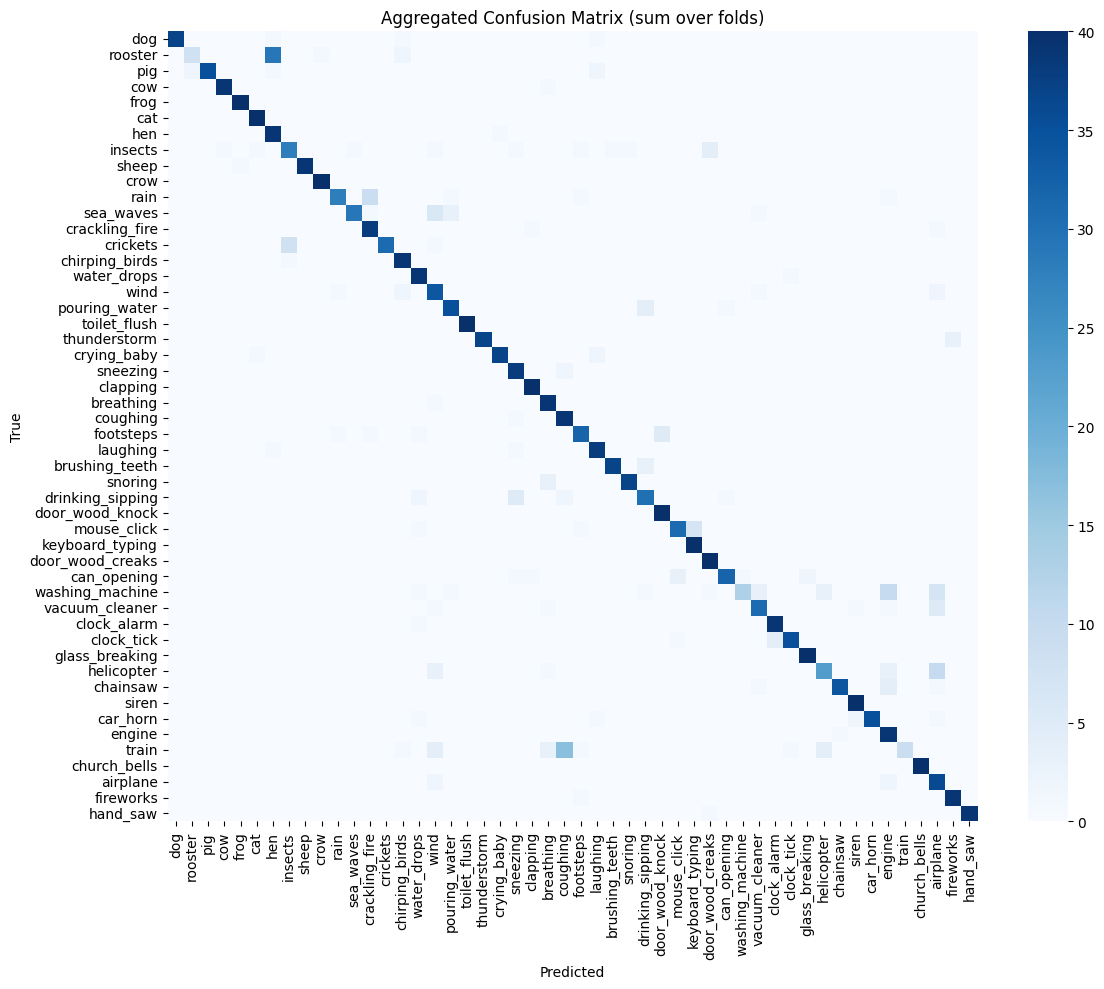

In [13]:
residual_dir = os.path.join(save_dir, DATASET, "ResiDual")
E.visualize_eval_metrics(residual_dir, DATASET, DATASETS[DATASET]["n_folds"], [0]) # inject layer: 0

## Evaluation of Linear CLAP

In [10]:
L.train_and_eval_linear_head(clap, DATASET, folds, len(DATASETS[DATASET]["class_labels"]), save_dir, epochs=5)

===== Eval fold 0 =====
=== Epoch 0 ===


Training (supervised): 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Train loss: 3.248201513290405, Train accuracy: 0.650625


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


=== Epoch 1 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Train loss: 1.8784177541732787, Train accuracy: 0.953125


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


=== Epoch 2 ===


Training (supervised): 100%|██████████| 25/25 [00:39<00:00,  1.57s/it]


Train loss: 1.0158596301078797, Train accuracy: 0.976875


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


=== Epoch 3 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Train loss: 0.5895667469501495, Train accuracy: 0.980625


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


=== Epoch 4 ===


Training (supervised): 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Train loss: 0.39297508597373965, Train accuracy: 0.985


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


===== Eval fold 1 =====
=== Epoch 0 ===


Training (supervised): 100%|██████████| 25/25 [00:38<00:00,  1.52s/it]


Train loss: 3.162960271835327, Train accuracy: 0.713125


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


=== Epoch 1 ===


Training (supervised): 100%|██████████| 25/25 [00:38<00:00,  1.56s/it]


Train loss: 1.7576934242248534, Train accuracy: 0.965


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


=== Epoch 2 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Train loss: 0.9279352140426635, Train accuracy: 0.975625


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


=== Epoch 3 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Train loss: 0.5407530665397644, Train accuracy: 0.978125


Evaluating (supervised): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


=== Epoch 4 ===


Training (supervised): 100%|██████████| 25/25 [00:38<00:00,  1.52s/it]


Train loss: 0.3664232009649277, Train accuracy: 0.980625


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


===== Eval fold 2 =====
=== Epoch 0 ===


Training (supervised): 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Train loss: 3.1556486892700195, Train accuracy: 0.706875


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


=== Epoch 1 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Train loss: 1.7574131107330322, Train accuracy: 0.969375


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


=== Epoch 2 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


Train loss: 0.9276387000083923, Train accuracy: 0.9775


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


=== Epoch 3 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Train loss: 0.5389806067943573, Train accuracy: 0.98


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


=== Epoch 4 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Train loss: 0.362799836397171, Train accuracy: 0.985625


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


===== Eval fold 3 =====
=== Epoch 0 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Train loss: 3.172719440460205, Train accuracy: 0.71125


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


=== Epoch 1 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Train loss: 1.7825380849838257, Train accuracy: 0.965625


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


=== Epoch 2 ===


Training (supervised): 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Train loss: 0.9526979160308838, Train accuracy: 0.971875


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


=== Epoch 3 ===


Training (supervised): 100%|██████████| 25/25 [00:38<00:00,  1.54s/it]


Train loss: 0.559274685382843, Train accuracy: 0.979375


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


=== Epoch 4 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


Train loss: 0.37899524927139283, Train accuracy: 0.983125


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


===== Eval fold 4 =====
=== Epoch 0 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


Train loss: 3.1505762767791747, Train accuracy: 0.715625


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


=== Epoch 1 ===


Training (supervised): 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Train loss: 1.7434927940368652, Train accuracy: 0.966875


Evaluating (supervised): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


=== Epoch 2 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Train loss: 0.9114304184913635, Train accuracy: 0.975


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


=== Epoch 3 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Train loss: 0.5269939041137696, Train accuracy: 0.98125


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


=== Epoch 4 ===


Training (supervised): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Train loss: 0.3550049936771393, Train accuracy: 0.983125


Evaluating (supervised): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


== Cross-Fold Evaluation Metrics ==
Top-1 Accuracy:   0.9775 ± 0.0073
Top-5 Accuracy:  0.9990 ± 0.0014
Precision: 0.9805 ± 0.0057
Recall:    0.9775 ± 0.0073
F1:        0.9770 ± 0.0076


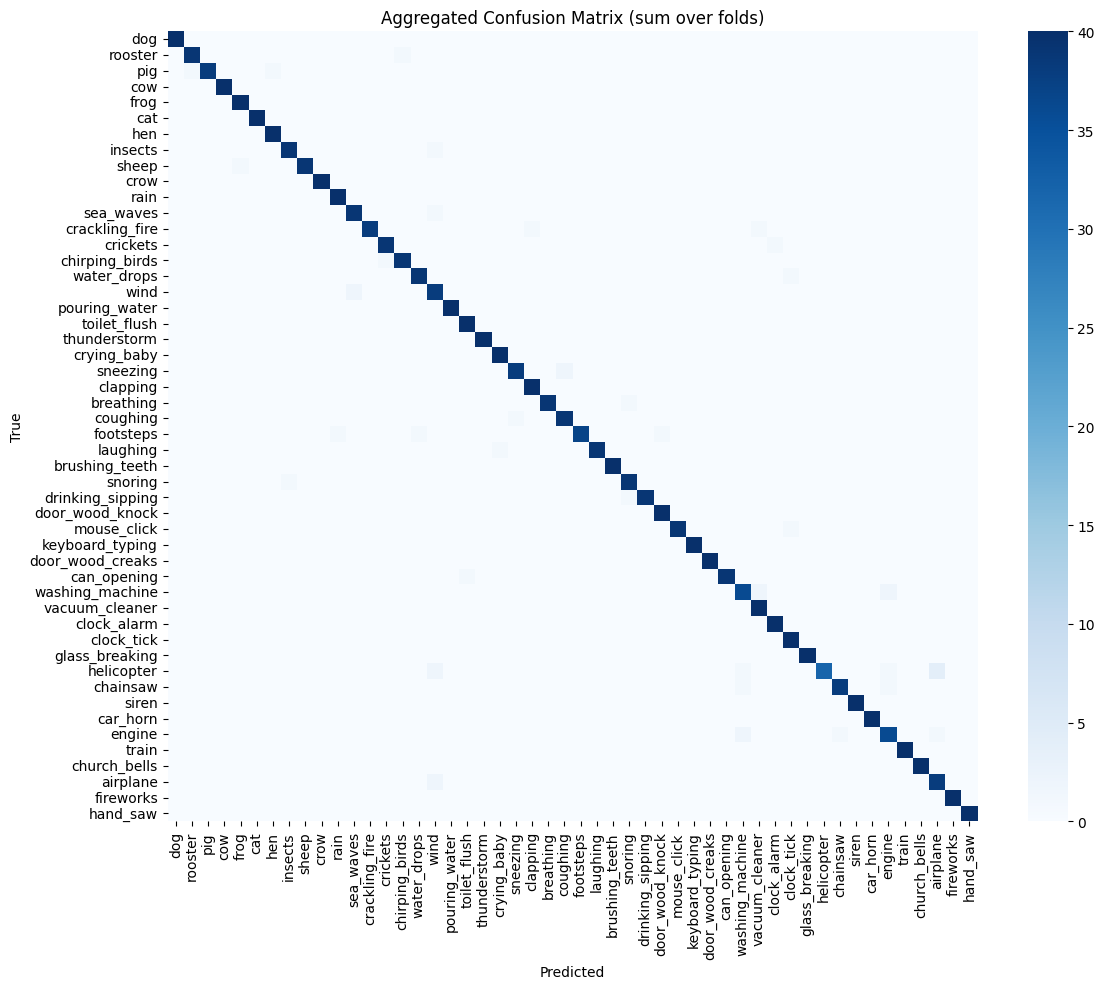

In [11]:
linear_dir = os.path.join(save_dir, DATASET, "Linear")
E.visualize_eval_metrics(linear_dir, DATASET, DATASETS[DATASET]["n_folds"], [])